In [1]:
# Demo Video: https://drive.google.com/drive/folders/1i7rX3EcOSszXGcAlBZUiCW-dh6gltWW9?usp=sharing

# EE353: Assignment 1
## *Sravan K Suresh*
## 22B3936

> "Data Scientists spend 80% of their time on getting data, cleaning data, aggregating data, reshaping data, and exploring data using exploratory data analysis and data visualization."

The purpose of this EDA is to find insights for Data cleaning/preparation/transformation which may ultimately be used into a machine learning algorithm.
We will proceed as follows:

<img src="http://sharpsightlabs.com/wp-content/uploads/2016/05/1_data-analysis-for-ML_how-we-use-dataAnalysis_2016-05-16.png" />

[Source](http://sharpsightlabs.com/blog/data-analysis-machine-learning-example-1/)


### Importing all the required packages and libraries

In [2]:
# The libraries may or may not be present on individual local systems, 
# so I'm installing them here whatsoever so as to make the notebook self-executable

!pip install --upgrade pip
!pip install pandas matplotlib seaborn sqlalchemy psycopg2

# Importing libraries
import pandas as pd
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
import numpy as np
import statsmodels.api as sm
from scipy import stats

### Downloading the datasets from URL given in Problem statement and loading them onto Pandas Dataframe

In [3]:
# Direct download links for the datasets (replace with actual CSV URLs)
health_inspections_csv_url = "https://data.lacity.org/api/views/29fd-3paw/rows.csv?accessType=DOWNLOAD"
affordable_housing_csv_url = "https://data.lacity.org/api/views/mymu-zi3s/rows.csv?accessType=DOWNLOAD"

# Function to download and save CSV files
def download_csv(url, filename):
    response = requests.get(url)
    if response.status_code == 200:
        with open(filename, 'wb') as file:
            file.write(response.content)
        print(f"Downloaded and saved {filename}")
    else:
        print(f"Failed to download {url}")

# Download the datasets
download_csv(health_inspections_csv_url, 'health_inspections.csv')
download_csv(affordable_housing_csv_url, 'affordable_housing.csv')

# Source 1

Downloaded and saved health_inspections.csv
Downloaded and saved affordable_housing.csv


In [4]:
# Load datasets into pandas DataFrames
health_df = pd.read_csv('health_inspections.csv')
housing_df = pd.read_csv('affordable_housing.csv')

## # ALWAYS, first explore data through printing and visualization
### I want to know what all are loaded there in the dataframe now, only then I'd proceed with the analysis!

In [41]:
# Display the first few rows of each dataframe to inspect the structure
print("Health Inspections DataFrame:")
print(health_df.head())

print("\n------------------------------------------------------------------------")
print("=========================================================================")
print("------------------------------------------------------------------------")

print("\nAffordable Housing DataFrame:")
print(housing_df.head())

Health Inspections DataFrame:
  serial_number           activity_date        facility_name  score grade  \
0     DAJ00E07B  12/29/2017 12:00:00 AM  HABITAT COFFEE SHOP     95     A   
1     DAQOKRFZB  12/29/2017 12:00:00 AM             REILLY'S     92     A   
2     DASJI4LUR  12/29/2017 12:00:00 AM       STREET CHURROS     93     A   
4     DAXV2RMYC  12/29/2017 12:00:00 AM               POLLEN     94     A   
5     DAMV56BMJ  12/29/2017 12:00:00 AM       THE SPOT GRILL     93     A   

   service_code service_description employee_id           facility_address  \
0             1  ROUTINE INSPECTION   EE0000923     3708 N EAGLE ROCK BLVD   
1             1  ROUTINE INSPECTION   EE0000633        100 WORLD WAY # 120   
2             1  ROUTINE INSPECTION   EE0000835  6801 HOLLYWOOD BLVD # 253   
4             1  ROUTINE INSPECTION   EE0000923         2100 ECHO PARK AVE   
5             1  ROUTINE INSPECTION   EE0000727        10004 NATIONAL BLVD   

  facility_city facility_id facility_s

In [6]:
# Replace occurrences of 401 with 0 in the 'service_code' column of the DataFrame
health_df['service_code'] = health_df['service_code'].replace({401: 0})

# Calculate the frequency of each unique value in the 'pe_description' column
description_counts = health_df['pe_description'].value_counts()

# Create a new DataFrame to hold the counts, using 'pe_description' values as index
description_distribution = pd.DataFrame({'Count': description_counts})
description_distribution

,Count
pe_description,
RESTAURANT (0-30) SEATS HIGH RISK,15885
RESTAURANT (31-60) SEATS HIGH RISK,10762
RESTAURANT (0-30) SEATS MODERATE RISK,10621
RESTAURANT (61-150) SEATS HIGH RISK,7904
"FOOD MKT RETAIL (1-1,999 SF) LOW RISK",5424
RESTAURANT (151 + ) SEATS HIGH RISK,2852
"FOOD MKT RETAIL (1-1,999 SF) HIGH RISK",2573
RESTAURANT (31-60) SEATS MODERATE RISK,1927
RESTAURANT (0-30) SEATS LOW RISK,1751


<Axes: ylabel='pe_description'>

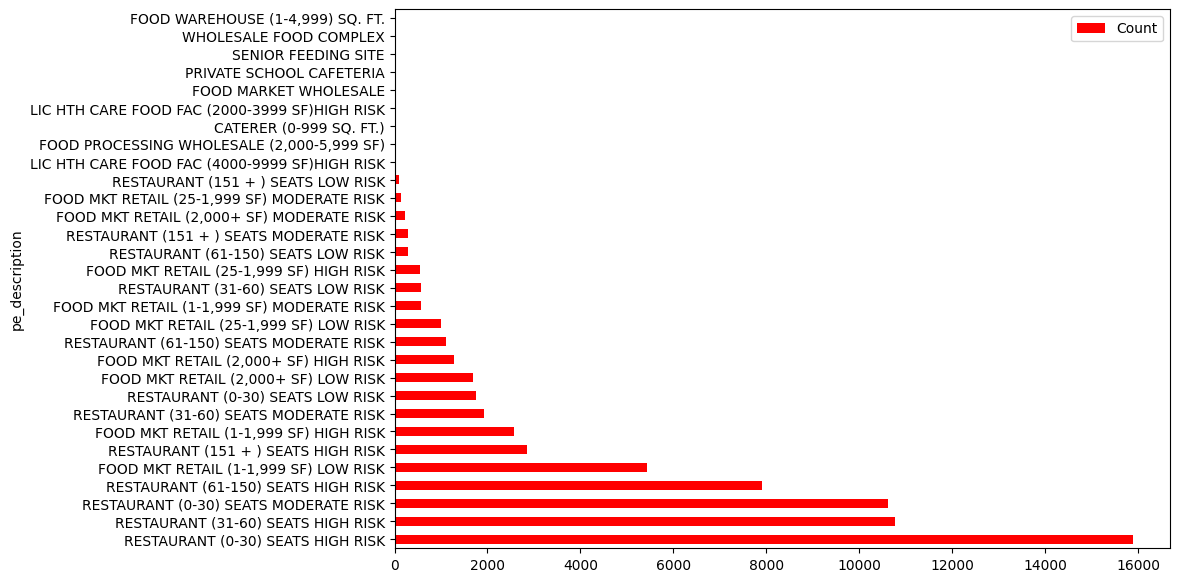

In [7]:
# Plot a horizontal bar chart of the description counts
description_distribution.plot(kind='barh', color='red', figsize=(10, 7))

Text(0.5, 1.0, 'Distribution of Risk Levels')

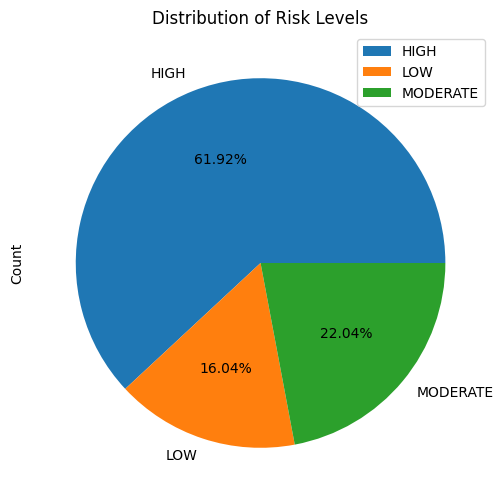

In [8]:
def extract_risk_description(text):
    # Get the second-to-last word from the string
    risk_desc = text.split(' ')[-2]
    # Clean up and standardize the risk description
    return risk_desc.strip().upper()

# Select rows from 'health_df' where 'pe_description' ends with 'RISK'
subset_df = health_df[health_df['pe_description'].str.endswith('RISK', na=False)].copy()

# Apply the risk extraction function and create a new column 'risk_level'
subset_df['risk_level'] = subset_df['pe_description'].astype(str).apply(extract_risk_description)

# Define a mapping for standardizing risk descriptions
risk_standardization = {
    'HIGH': 'HIGH',
    'SF)HIGH': 'HIGH',
    # Additional mappings can be included here
}

# Map the extracted risk descriptions to standardized values
subset_df['risk_level'] = subset_df['risk_level'].map(risk_standardization).fillna(subset_df['risk_level'])

# Aggregate the data by the 'risk_level' column and count the occurrences
risk_counts = subset_df.groupby('risk_level').size()

# Convert the aggregated data into a DataFrame
risk_summary = pd.DataFrame({'Count': risk_counts.values}, index=risk_counts.index)

# Plot the distribution of risks using a pie chart
pie_chart = risk_summary['Count'].plot(kind="pie", legend=True, autopct='%.2f%%', figsize=(6, 6))
pie_chart.set_title("Distribution of Risk Levels")

In [9]:
# Handling missing values (if any)
print("\nMissing values in Health Inspections Data:")
print(health_df.isnull().sum())
print("\nMissing values in Affordable Housing Data:")
print(housing_df.isnull().sum())


Missing values in Health Inspections Data:
serial_number           0
activity_date           0
facility_name           0
score                   0
grade                   3
service_code            0
service_description     0
employee_id             0
facility_address        0
facility_city           0
facility_id             0
facility_state          0
facility_zip            0
owner_id                0
owner_name              0
pe_description          0
program_element_pe      0
program_name           29
program_status          0
record_id               0
dtype: int64

Missing values in Affordable Housing Data:
APN                          0
PROJECT NUMBER               0
NAME                         0
DEVELOPMENT STAGE            1
CONSTRUCTION TYPE           34
SITE ADDRESS                 0
SITE  COUNCIL DISTRICT       0
SITE #                       0
SITE COMMUNITY               7
SITE UNITS                   0
PROJECT TOTAL UNITS          0
HOUSING TYPE                22
SUPPORT

In [10]:
# Handling missing values in Health Inspections DataFrame

# Fill missing grades with 'Unknown'
health_df['grade'] = health_df['grade'].fillna('Unknown')

# Fill missing program names with 'Unknown'
health_df['program_name'] = health_df['program_name'].fillna('Unknown')

# Confirm no missing values remain
print("Missing values in Health Inspections Data after handling:")
print(health_df.isnull().sum())

# Handling missing values in Affordable Housing DataFrame

# Fill categorical columns with 'Unknown'
categorical_columns = ['DEVELOPMENT STAGE', 'CONSTRUCTION TYPE', 'HOUSING TYPE', 'DATE FUNDED',
                       'DEVELOPER', 'MANAGEMENT COMPANY', 'CONTACT PHONE', 'CONTRACT NUMBERS']
housing_df[categorical_columns] = housing_df[categorical_columns].fillna('Unknown')

# Fill numerical columns with 0 or median depending on the context
housing_df['JOBS'] = housing_df['JOBS'].fillna(0)

# For SITE COMMUNITY, fill with 'Unknown'
housing_df['SITE COMMUNITY'] = housing_df['SITE COMMUNITY'].fillna('Unknown')

# If DEVELOPMENT STAGE is important, fill with 'Unknown'
housing_df['DEVELOPMENT STAGE'] = housing_df['DEVELOPMENT STAGE'].fillna('Unknown')

# Confirm no missing values remain
print("Missing values in Affordable Housing Data after handling:")
print(housing_df.isnull().sum())

# Source 2- I have studied imputation methods for various kinds of missing data values from here

Missing values in Health Inspections Data after handling:
serial_number          0
activity_date          0
facility_name          0
score                  0
grade                  0
service_code           0
service_description    0
employee_id            0
facility_address       0
facility_city          0
facility_id            0
facility_state         0
facility_zip           0
owner_id               0
owner_name             0
pe_description         0
program_element_pe     0
program_name           0
program_status         0
record_id              0
dtype: int64
Missing values in Affordable Housing Data after handling:
APN                        0
PROJECT NUMBER             0
NAME                       0
DEVELOPMENT STAGE          0
CONSTRUCTION TYPE          0
SITE ADDRESS               0
SITE  COUNCIL DISTRICT     0
SITE #                     0
SITE COMMUNITY             0
SITE UNITS                 0
PROJECT TOTAL UNITS        0
HOUSING TYPE               0
SUPPORTIVE HOUSING     

### Detecting and Correcting Unexpected Entries

In [11]:
# Check the columns of the housing_df to verify if the 'ZIP' column exists
print("Columns in the Affordable Housing DataFrame:")
print(housing_df.columns)

Columns in the Affordable Housing DataFrame:
Index(['APN', 'PROJECT NUMBER', 'NAME', 'DEVELOPMENT STAGE',
       'CONSTRUCTION TYPE', 'SITE ADDRESS', 'SITE  COUNCIL DISTRICT', 'SITE #',
       'SITE COMMUNITY', 'SITE UNITS', 'PROJECT TOTAL UNITS', 'HOUSING TYPE',
       'SUPPORTIVE HOUSING', 'SH UNITS PER SITE', 'DATE FUNDED', 'LAHD FUNDED',
       'LEVERAGE', 'TAX EXEMPT CONDUIT BOND', 'TDC', 'IN-SERVICE DATE',
       'DEVELOPER', 'MANAGEMENT COMPANY', 'CONTACT PHONE', 'PHOTO', 'JOBS',
       'PROJECT SUMMARY URL', 'CONTRACT NUMBERS', 'DATE STAMP',
       'SITE LONGITUDE', 'SITE LATITUDE', 'GPS_COORDS ON MAP'],
      dtype='object')


In [12]:
# 'ZIP' column doesn't exist :( 
# I'll re-extract it from 'SITE ADDRESS'
if 'ZIP' not in housing_df.columns:
    # Extract ZIP code from SITE ADDRESS in housing dataframe
    housing_df['ZIP'] = housing_df['SITE ADDRESS'].apply(lambda x: x.strip().split()[-1])

# Display the first few rows to confirm extraction
print("\nFirst few rows after extracting ZIP:")
print(housing_df[['SITE ADDRESS', 'ZIP']].head())


First few rows after extracting ZIP:
                                        SITE ADDRESS    ZIP
0               1221 W 7TH ST  Los Angeles, CA 90017  90017
1            2809 S WEST BLVD  Los Angeles, CA 90016  90016
2  1037 E MARTIN LUTHER KING BLVD  LOS ANGELES, C...  90011
3        7305 S CRENSHAW BLVD  Los Angeles, CA 90043  90043
4             116 S WITMER ST  Los Angeles, CA 90026  90026


In [13]:
# Detecting and Correcting Unexpected Entries

# 1. Out-of-range values in Health Inspections DataFrame
invalid_scores = health_df[(health_df['score'] < 0) | (health_df['score'] > 100)]
print("Out-of-range scores detected:")
print(invalid_scores)

# Correct by setting out-of-range scores to NaN or to a fixed value (e.g., the median score)
health_df['score'] = health_df['score'].apply(lambda x: x if 0 <= x <= 100 else health_df['score'].median())

# 2. Invalid ZIP codes
invalid_zips_health = health_df[~health_df['facility_zip'].str.match(r'^\d{5}$')]
print("\nInvalid ZIP codes in Health Inspections DataFrame:")
print(invalid_zips_health[['facility_zip']].drop_duplicates())

# Correct invalid ZIP codes by dropping them or filling with a valid value
# Example: Drop rows with invalid ZIP codes
health_df = health_df[health_df['facility_zip'].str.match(r'^\d{5}$')]

# Similarly, check for invalid ZIP codes in the Affordable Housing DataFrame
invalid_zips_housing = housing_df[~housing_df['ZIP'].str.match(r'^\d{5}$')]
print("\nInvalid ZIP codes in Affordable Housing DataFrame:")
print(invalid_zips_housing[['ZIP']].drop_duplicates())

# Correct invalid ZIP codes
housing_df = housing_df[housing_df['ZIP'].str.match(r'^\d{5}$')]

# 3. Unexpected values in categorical fields (e.g., 'grade')
expected_grades = {'A', 'B', 'C', 'Unknown'}  # Set of expected grades
unexpected_grades = health_df[~health_df['grade'].isin(expected_grades)]
print("\nUnexpected grades detected:")
print(unexpected_grades[['grade']].drop_duplicates())

# Correct by setting unexpected grades to 'Unknown'
health_df['grade'] = health_df['grade'].apply(lambda x: x if x in expected_grades else 'Unknown')

# Source 3

Out-of-range scores detected:
Empty DataFrame
Columns: [serial_number, activity_date, facility_name, score, grade, service_code, service_description, employee_id, facility_address, facility_city, facility_id, facility_state, facility_zip, owner_id, owner_name, pe_description, program_element_pe, program_name, program_status, record_id]
Index: []

Invalid ZIP codes in Health Inspections DataFrame:
      facility_zip
3       90026-3227
6       90043-4706
25      90015-2392
31      90057-3344
53      90013-1902
...            ...
67197   90006-5806
67284   90018-1252
67287   90014-2106
67548   90013-2345
67551   90015-3135

[956 rows x 1 columns]

Invalid ZIP codes in Affordable Housing DataFrame:
Empty DataFrame
Columns: [ZIP]
Index: []

Unexpected grades detected:
      grade
34297      


### Okay, I think we're good to go with the data. Now, let's see how does our data 'look':
### <ins>Plotting Graphs to Understand the Data</ins>

In [14]:
# Continuous variables in Health Inspections DataFrame
continuous_vars_health = ['score']

# Continuous variables in Affordable Housing DataFrame
continuous_vars_housing = ['SITE UNITS', 'JOBS', 'TDC']

# Summarized continuous variables for plotting relationships
continuous_vars_merged = ['avg_score', 'inspection_count', 'total_affordable_units']

#### a. Distribution of Health Inspection Scores, Affordable Housing Units and Jobs Created

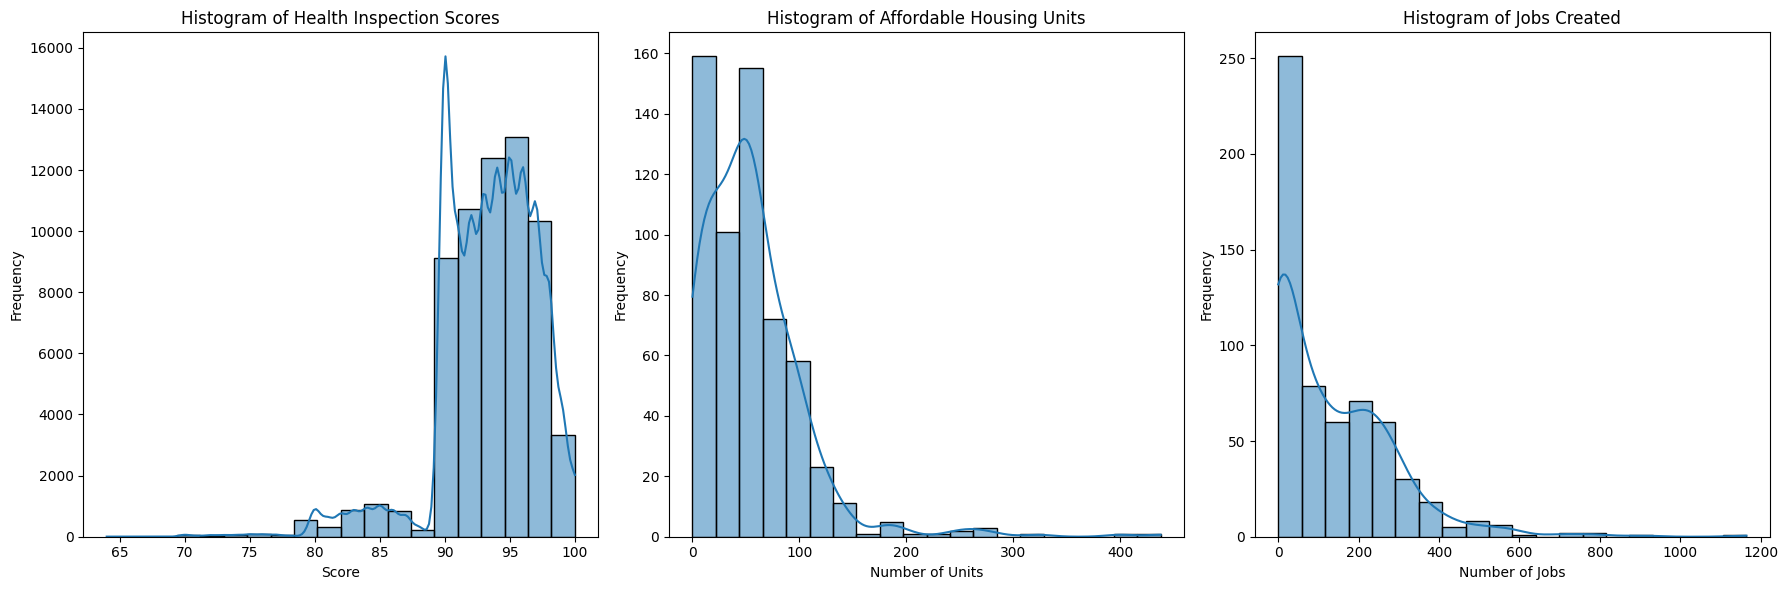

In [15]:
# Set up the figure and axes for histograms
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Plotting histograms for continuous variables
sns.histplot(health_df['score'], kde=True, bins=20, ax=axs[0])
axs[0].set_title('Histogram of Health Inspection Scores')
axs[0].set_xlabel('Score')
axs[0].set_ylabel('Frequency')

sns.histplot(housing_df['SITE UNITS'], kde=True, bins=20, ax=axs[1])
axs[1].set_title('Histogram of Affordable Housing Units')
axs[1].set_xlabel('Number of Units')
axs[1].set_ylabel('Frequency')

sns.histplot(housing_df['JOBS'], kde=True, bins=20, ax=axs[2])
axs[2].set_title('Histogram of Jobs Created')
axs[2].set_xlabel('Number of Jobs')
axs[2].set_ylabel('Frequency')

# Adjust layout
plt.tight_layout()
plt.show()

#### b. Distribution of Grades

C:\Users\ASUS\AppData\Local\Temp\ipykernel_24368\998776237.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=health_df, x='grade', palette='coolwarm')


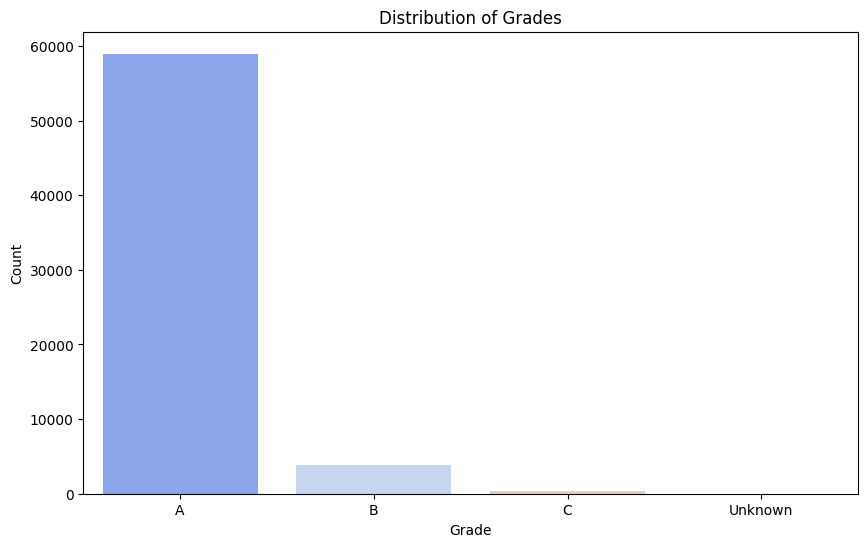

In [16]:
plt.figure(figsize=(10, 6))
sns.countplot(data=health_df, x='grade', palette='coolwarm')
plt.title('Distribution of Grades')
plt.xlabel('Grade')
plt.ylabel('Count')
plt.show()

#### c. Distribution of Affordable Housing Units by ZIP Code

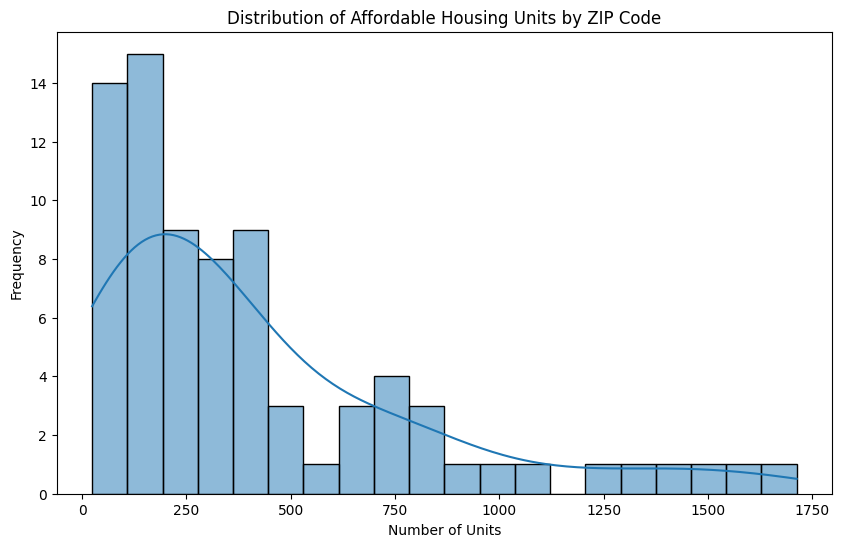

In [17]:
housing_units_by_zip = housing_df.groupby('ZIP')['SITE UNITS'].sum().reset_index()

plt.figure(figsize=(10, 6))
sns.histplot(housing_units_by_zip['SITE UNITS'], kde=True, bins=20)
plt.title('Distribution of Affordable Housing Units by ZIP Code')
plt.xlabel('Number of Units')
plt.ylabel('Frequency')
plt.show()

#### d. Scatter Plot: Affordable Housing Units vs. Health Inspection Scores by ZIP Code

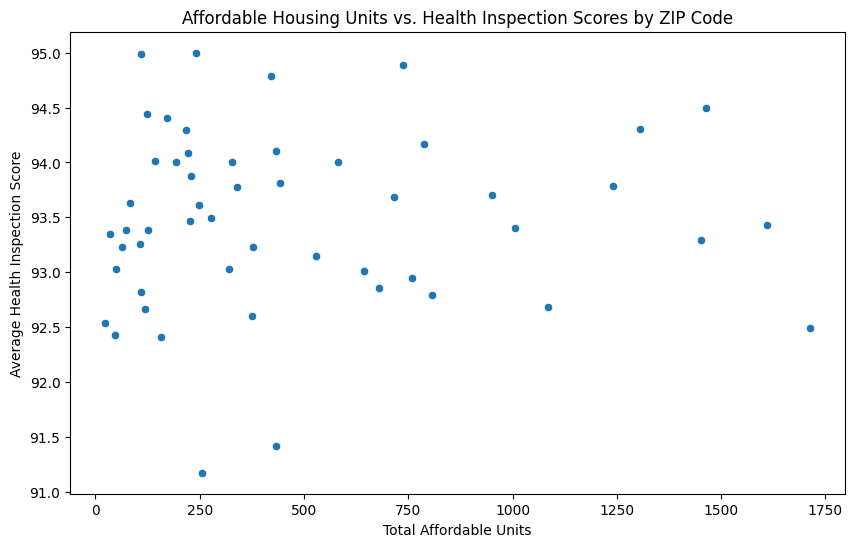

In [18]:
# Summarize health scores by ZIP code
health_summary = health_df.groupby('facility_zip').agg(
    avg_score=('score', 'mean'),
    inspection_count=('score', 'count')
).reset_index()

# Summarize affordable housing units by ZIP code
housing_summary = housing_df.groupby('ZIP').agg(
    total_affordable_units=('SITE UNITS', 'sum')
).reset_index()

# Merge the summaries by ZIP code
merged_data = pd.merge(health_summary, housing_summary, left_on='facility_zip', right_on='ZIP', how='inner')

plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='total_affordable_units', y='avg_score')
plt.title('Affordable Housing Units vs. Health Inspection Scores by ZIP Code')
plt.xlabel('Total Affordable Units')
plt.ylabel('Average Health Inspection Score')
plt.show()

#### e. Subplots of histograms and Scatter-plots for all continuous variables with appropriate number of bins

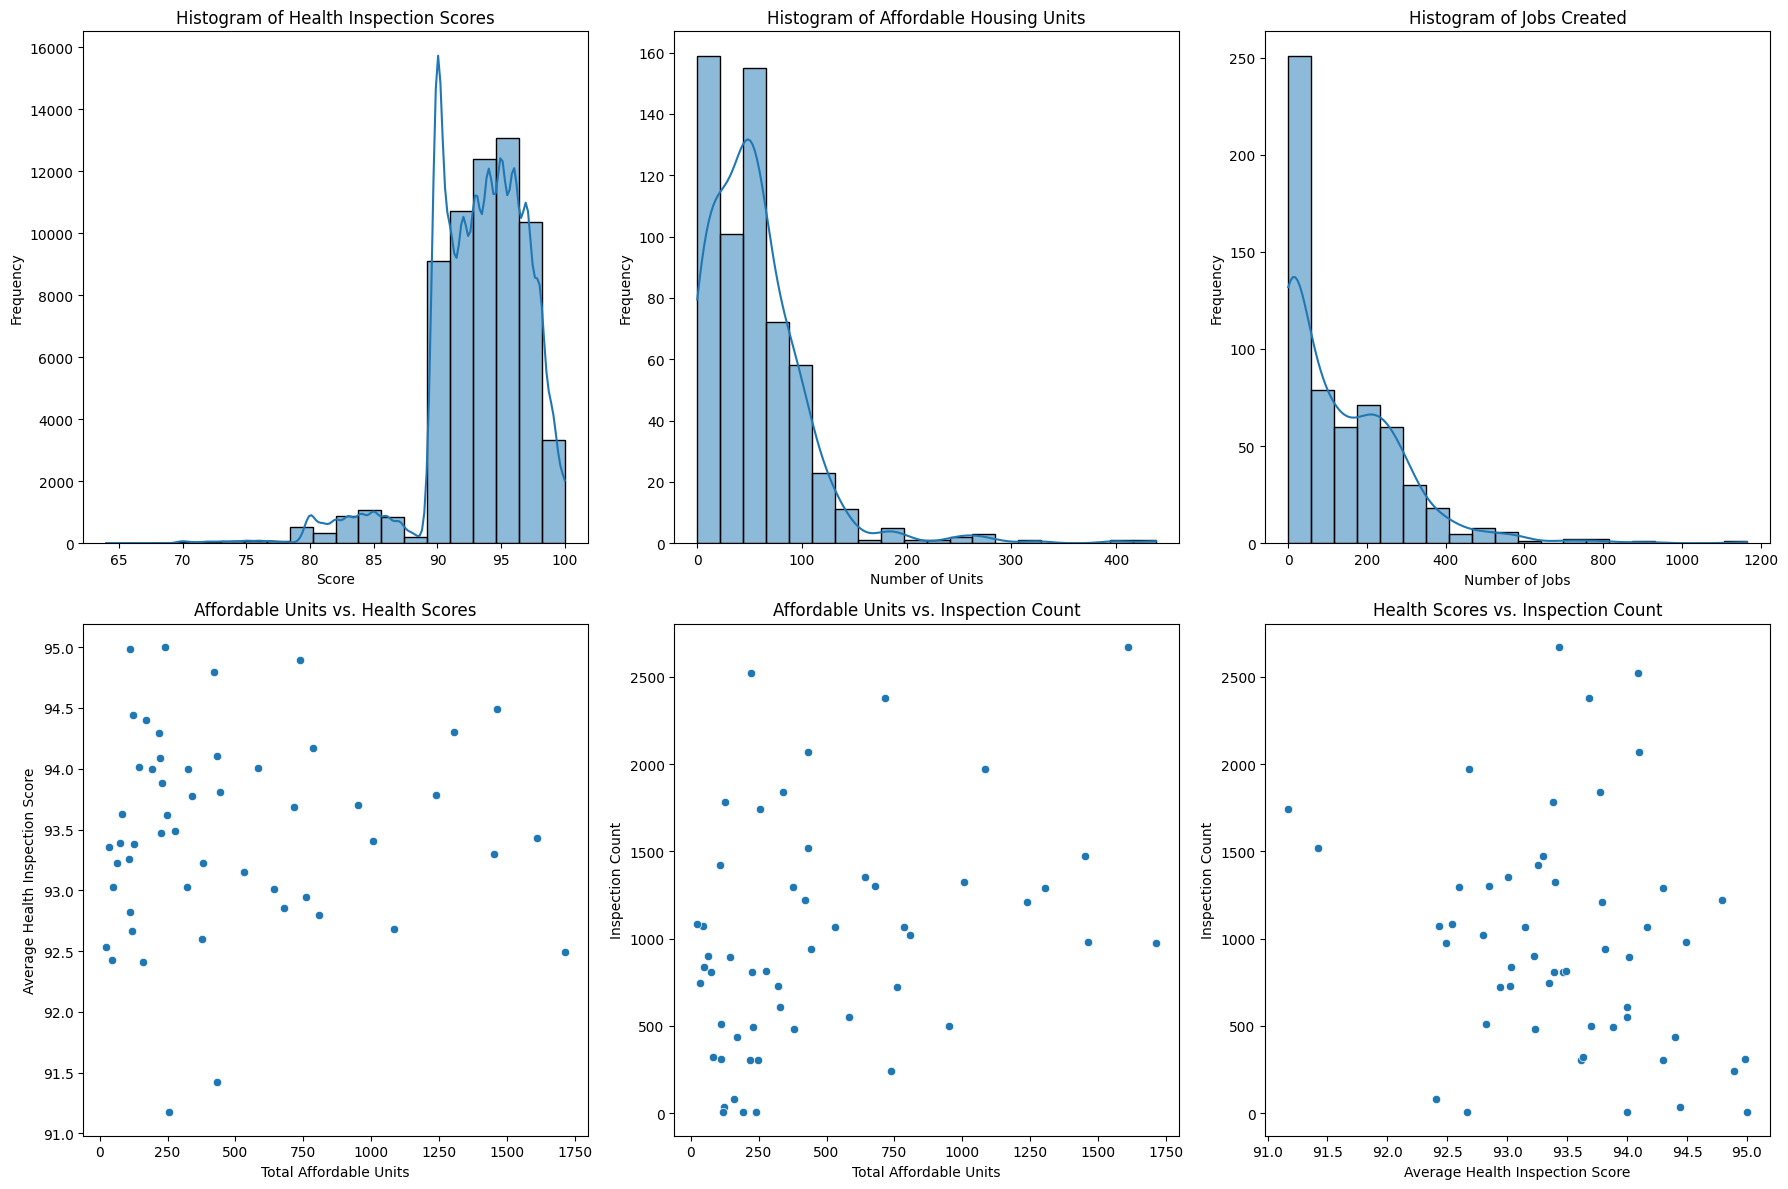

In [19]:
# Set up the figure and axes
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Plotting histograms for continuous variables
sns.histplot(health_df['score'], kde=True, bins=20, ax=axs[0, 0])
axs[0, 0].set_title('Histogram of Health Inspection Scores')
axs[0, 0].set_xlabel('Score')
axs[0, 0].set_ylabel('Frequency')

sns.histplot(housing_df['SITE UNITS'], kde=True, bins=20, ax=axs[0, 1])
axs[0, 1].set_title('Histogram of Affordable Housing Units')
axs[0, 1].set_xlabel('Number of Units')
axs[0, 1].set_ylabel('Frequency')

sns.histplot(housing_df['JOBS'], kde=True, bins=20, ax=axs[0, 2])
axs[0, 2].set_title('Histogram of Jobs Created')
axs[0, 2].set_xlabel('Number of Jobs')
axs[0, 2].set_ylabel('Frequency')

# Scatter plots to visualize relationships
sns.scatterplot(data=merged_data, x='total_affordable_units', y='avg_score', ax=axs[1, 0])
axs[1, 0].set_title('Affordable Units vs. Health Scores')
axs[1, 0].set_xlabel('Total Affordable Units')
axs[1, 0].set_ylabel('Average Health Inspection Score')

sns.scatterplot(data=merged_data, x='total_affordable_units', y='inspection_count', ax=axs[1, 1])
axs[1, 1].set_title('Affordable Units vs. Inspection Count')
axs[1, 1].set_xlabel('Total Affordable Units')
axs[1, 1].set_ylabel('Inspection Count')

sns.scatterplot(data=merged_data, x='avg_score', y='inspection_count', ax=axs[1, 2])
axs[1, 2].set_title('Health Scores vs. Inspection Count')
axs[1, 2].set_xlabel('Average Health Inspection Score')
axs[1, 2].set_ylabel('Inspection Count')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

#### f. Correlation Heatmap

                        avg_score  inspection_count  total_affordable_units
avg_score                1.000000         -0.240673                0.028155
inspection_count        -0.240673          1.000000                0.369918
total_affordable_units   0.028155          0.369918                1.000000


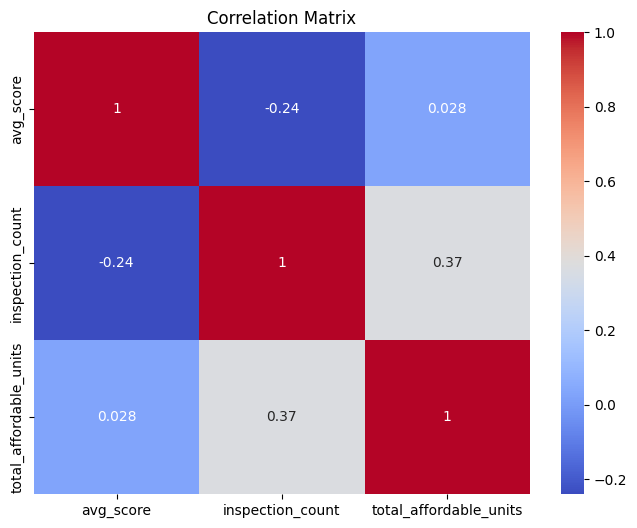

In [20]:
plt.figure(figsize=(8, 6))
correlation_matrix = merged_data[['avg_score', 'inspection_count', 'total_affordable_units']].corr()
print(correlation_matrix)
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


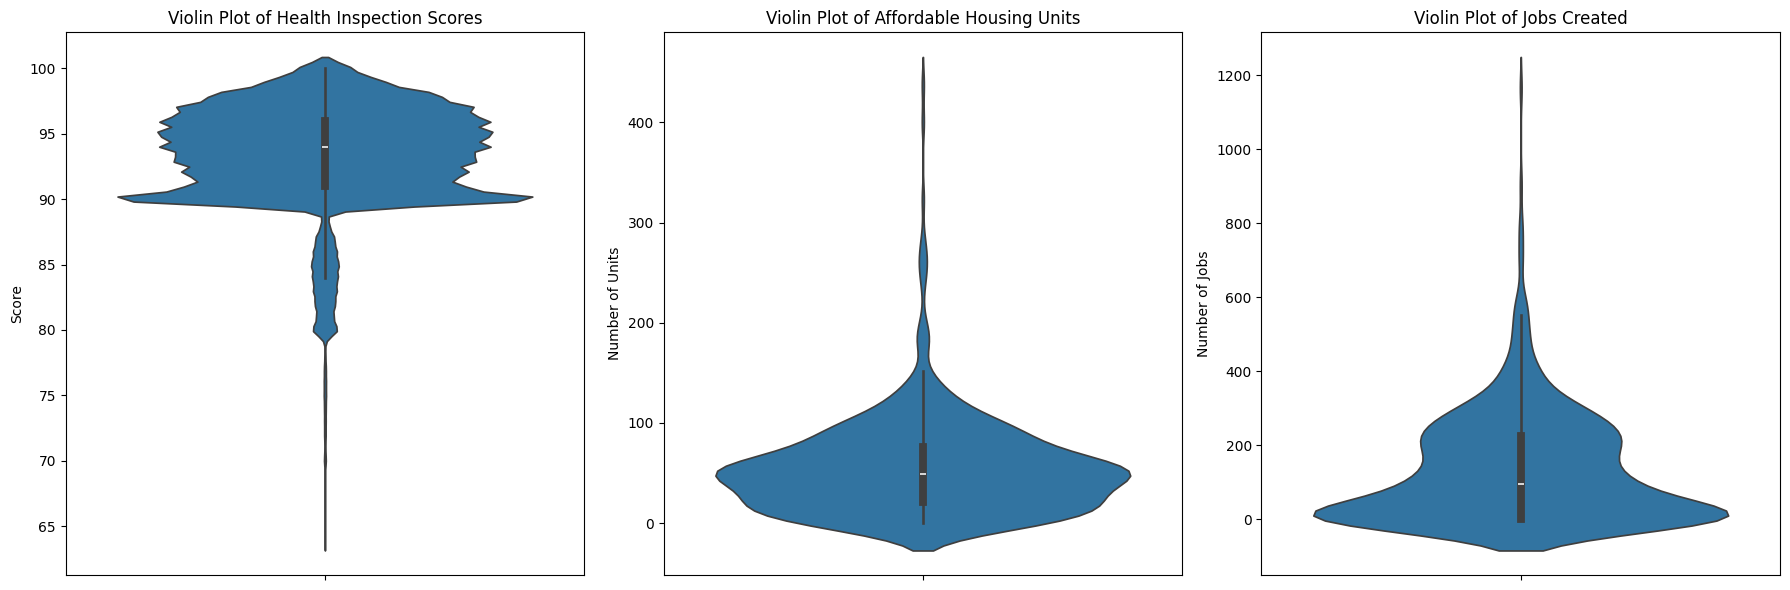

In [21]:
# Violin plots for all continuous variables
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Violin plot for health inspection scores
sns.violinplot(y=health_df['score'], ax=axs[0])
axs[0].set_title('Violin Plot of Health Inspection Scores')
axs[0].set_ylabel('Score')

# Violin plot for affordable housing units
sns.violinplot(y=housing_df['SITE UNITS'], ax=axs[1])
axs[1].set_title('Violin Plot of Affordable Housing Units')
axs[1].set_ylabel('Number of Units')

# Violin plot for jobs created
sns.violinplot(y=housing_df['JOBS'], ax=axs[2])
axs[2].set_title('Violin Plot of Jobs Created')
axs[2].set_ylabel('Number of Jobs')

plt.tight_layout()
plt.show()

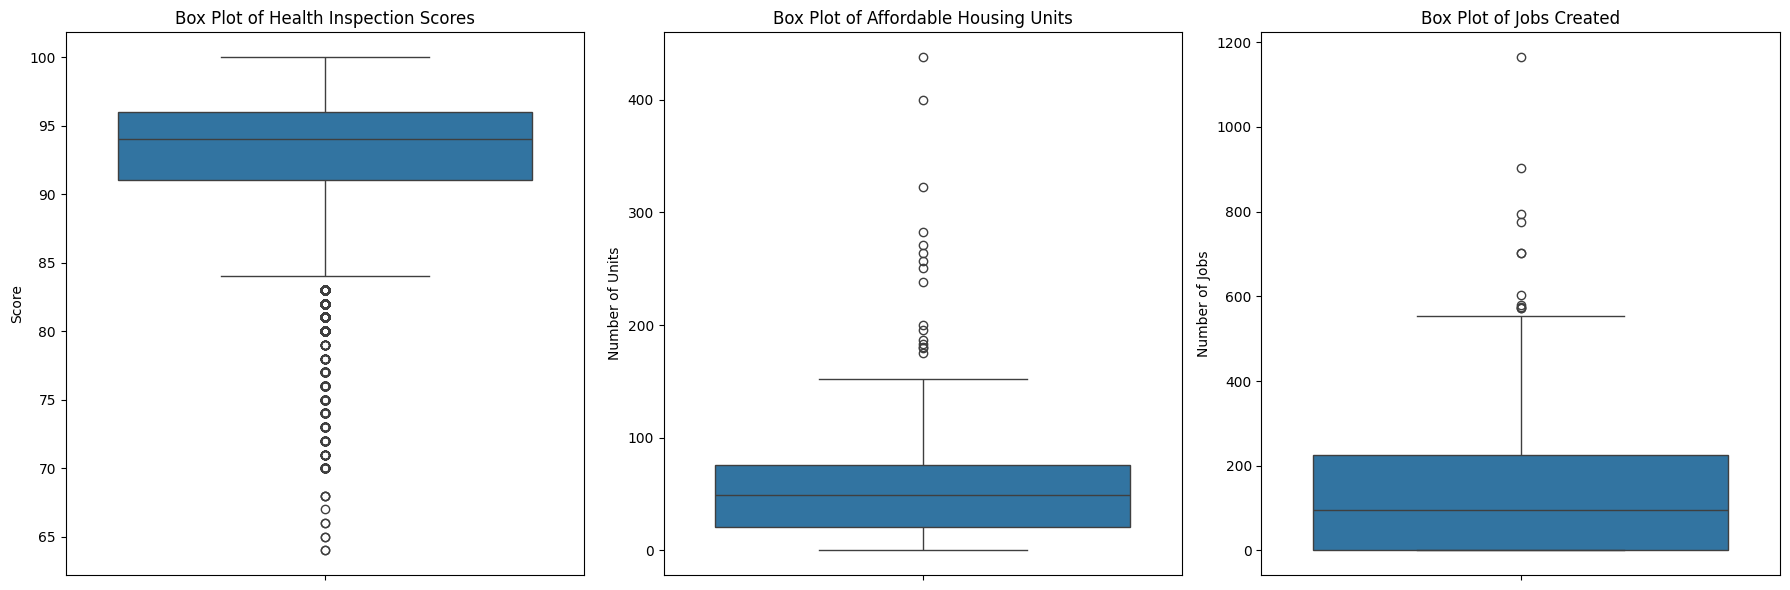

In [22]:
# Box plots for all continuous variables
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Box plot for health inspection scores
sns.boxplot(y=health_df['score'], ax=axs[0])
axs[0].set_title('Box Plot of Health Inspection Scores')
axs[0].set_ylabel('Score')

# Box plot for affordable housing units
sns.boxplot(y=housing_df['SITE UNITS'], ax=axs[1])
axs[1].set_title('Box Plot of Affordable Housing Units')
axs[1].set_ylabel('Number of Units')

# Box plot for jobs created
sns.boxplot(y=housing_df['JOBS'], ax=axs[2])
axs[2].set_title('Box Plot of Jobs Created')
axs[2].set_ylabel('Number of Jobs')

plt.tight_layout()
plt.show()

## Conclusions from Data Analysis

### Correlation Insights

1. **Correlation between Affordable Housing Units and Average Health Inspection Scores**:
   - The correlation coefficient is `0.028`. This suggests **no significant relationship** between the number of affordable housing units in a ZIP code and the average health inspection scores of restaurants in that ZIP code.

2. **Correlation between Affordable Housing Units and Inspection Count**:
   - The correlation coefficient is `0.370`. This indicates a **moderate positive relationship** between the number of affordable housing units and the frequency of health inspections. ZIP codes with more affordable housing units tend to have a slightly higher number of health inspections.

3. **Correlation between Average Health Scores and Inspection Count**:
   - The correlation coefficient is `-0.241`. This points to a **weak negative relationship** between the average health inspection scores and the number of inspections conducted. ZIP codes with more health inspections may slightly correlate with lower average scores, although this relationship is not strong.

### Visual Insights

- **Histograms**:
  - The histogram of health inspection scores shows that scores are mostly concentrated in the 90-100 range, indicating generally good health conditions in restaurants across different ZIP codes.
  - The distribution of affordable housing units is more varied, with many ZIP codes having fewer units and a few having a large number of units.
  - The distribution of job creation also shows variability, with a few ZIP codes contributing significantly to job creation.

- **Scatterplots**:
  - The scatterplot between affordable housing units and average health inspection scores shows no clear pattern, consistent with the low correlation coefficient.
  - The scatterplot between affordable housing units and inspection count shows a slight upward trend, suggesting more inspections occur in areas with more affordable housing units.
  - The scatterplot between average health scores and inspection count shows a slight downward trend, suggesting a weak tendency for average scores to be lower in areas with more inspections.

### Summary
Based on the analysis as of now, it appears that there is **limited evidence** of a strong relationship between affordable housing projects and health inspection scores in the City of Los Angeles. While there is a moderate positive correlation between the number of affordable housing units and the frequency of health inspections, the overall impact of affordable housing on the health inspection outcomes of restaurants seems minimal. This suggests that the concentration of affordable housing units may not be a strong predictor of restaurant health inspection outcomes.


#### Q.c) Summarize Health Inspections Data by ZIP Code

In [23]:
# Create an in-memory SQLite database
engine = create_engine('sqlite://', echo=False)

# Save the health_df to the SQL database
health_df.to_sql('health', con=engine, if_exists='replace', index=False)

# Summarize health inspection data by ZIP code
summary_health = pd.read_sql_query("""
    SELECT 
        facility_zip AS ZIP,
        AVG(score) AS avg_score,
        COUNT(score) AS inspection_count,
        MIN(score) AS min_score,
        MAX(score) AS max_score
    FROM health
    GROUP BY ZIP
""", con=engine)

# Display the summary
print("Health Inspections Summary by ZIP Code:")
print(summary_health.head())

# Source 4

Health Inspections Summary by ZIP Code:
     ZIP  avg_score  inspection_count  min_score  max_score
0  90001  93.853408              1071         71        100
1  90002  94.892562               242         72        100
2  90003  92.795299              1021         70        100
3  90004  92.851767              1302         72         99
4  90005  91.419631              1518         65        100


#### Q.c) Summarize Affordable Housing Data by ZIP Code

In [24]:
# Save the housing_df to the SQL database
housing_df.to_sql('housing', con=engine, if_exists='replace', index=False)

# Summarize affordable housing data by ZIP code
summary_housing = pd.read_sql_query("""
    SELECT 
        ZIP,
        SUM([SITE UNITS]) AS total_affordable_units,
        COUNT([PROJECT NUMBER]) AS project_count,
        MIN([SITE UNITS]) AS min_units,
        MAX([SITE UNITS]) AS max_units
    FROM housing
    GROUP BY ZIP
""", con=engine)

# Display the summary
print("Affordable Housing Summary by ZIP Code:")
print(summary_housing.head())

Affordable Housing Summary by ZIP Code:
     ZIP  total_affordable_units  project_count  min_units  max_units
0  90002                     738             19          0        135
1  90003                     808             21          0        257
2  90004                     679             13          0        122
3  90005                     433              4          0        283
4  90006                    1084             25          0        111


### Q.4) Join the Summarized DataFrames by ZIP Code

In [25]:
# Save the summarized health inspection data to the SQL database
summary_health.to_sql('summary_health', con=engine, if_exists='replace', index=False)

# Save the summarized affordable housing data to the SQL database
summary_housing.to_sql('summary_housing', con=engine, if_exists='replace', index=False)

# Now, perform the join operation
merged_data = pd.read_sql_query("""
    SELECT 
        h.ZIP,
        h.avg_score,
        h.inspection_count,
        h.min_score,
        h.max_score,
        a.total_affordable_units,
        a.project_count,
        a.min_units,
        a.max_units
    FROM summary_health h
    INNER JOIN summary_housing a
    ON h.ZIP = a.ZIP
""", con=engine)

# Display the joined data
print("Joined Data by ZIP Code:")
print(merged_data.head())


Joined Data by ZIP Code:
     ZIP  avg_score  inspection_count  min_score  max_score  \
0  90002  94.892562               242         72        100   
1  90003  92.795299              1021         70        100   
2  90004  92.851767              1302         72         99   
3  90005  91.419631              1518         65        100   
4  90006  92.680020              1972         70        100   

   total_affordable_units  project_count  min_units  max_units  
0                     738             19          0        135  
1                     808             21          0        257  
2                     679             13          0        122  
3                     433              4          0        283  
4                    1084             25          0        111  


In [26]:
# Ensure ZIP Code Compatibility
# Convert ZIP codes to string and ensure they are 5 characters long
summary_health['ZIP'] = summary_health['ZIP'].astype(str).str.zfill(5)
summary_housing['ZIP'] = summary_housing['ZIP'].astype(str).str.zfill(5)

# Display the first few rows to confirm ZIP code formatting
print("Formatted ZIP codes in Health Summary:")
print(summary_health[['ZIP']].head())

print("Formatted ZIP codes in Housing Summary:")
print(summary_housing[['ZIP']].head())

Formatted ZIP codes in Health Summary:
     ZIP
0  90001
1  90002
2  90003
3  90004
4  90005
Formatted ZIP codes in Housing Summary:
     ZIP
0  90002
1  90003
2  90004
3  90005
4  90006


In [27]:
# Merging the DataFrames to Get Predictor and Predicted Variables
# Merge on the ZIP code
merged_data = pd.merge(summary_health, summary_housing, on='ZIP', how='inner')

# Display the merged DataFrame to check the results
print("Merged Data with Predictor and Predicted Variables by ZIP Code:")
print(merged_data.head())

# Predictor: total_affordable_units
# Predicted: avg_score, inspection_count, min_score, max_score
selected_data = merged_data[['ZIP', 'total_affordable_units', 'avg_score', 'inspection_count', 'min_score', 'max_score']]

print("-------------------------------------------------------------------------------------")

# Display the selected data
print("Selected Predictor and Predicted Variables by ZIP Code:")
print(selected_data.head())


Merged Data with Predictor and Predicted Variables by ZIP Code:
     ZIP  avg_score  inspection_count  min_score  max_score  \
0  90002  94.892562               242         72        100   
1  90003  92.795299              1021         70        100   
2  90004  92.851767              1302         72         99   
3  90005  91.419631              1518         65        100   
4  90006  92.680020              1972         70        100   

   total_affordable_units  project_count  min_units  max_units  
0                     738             19          0        135  
1                     808             21          0        257  
2                     679             13          0        122  
3                     433              4          0        283  
4                    1084             25          0        111  
-------------------------------------------------------------------------------------
Selected Predictor and Predicted Variables by ZIP Code:
     ZIP  total_affordabl

## Statistical Analysis

### 1. Correlation Analysis
We will compute the correlation matrix to see if there's any linear relationship between the number of affordable housing units and health inspection scores.

Correlation Matrix:
                        total_affordable_units  avg_score  inspection_count  \
total_affordable_units                1.000000   0.028155          0.369918   
avg_score                             0.028155   1.000000         -0.240673   
inspection_count                      0.369918  -0.240673          1.000000   
min_score                            -0.208534   0.359755         -0.488343   
max_score                             0.168423  -0.053647          0.367320   

                        min_score  max_score  
total_affordable_units  -0.208534   0.168423  
avg_score                0.359755  -0.053647  
inspection_count        -0.488343   0.367320  
min_score                1.000000  -0.673713  
max_score               -0.673713   1.000000  


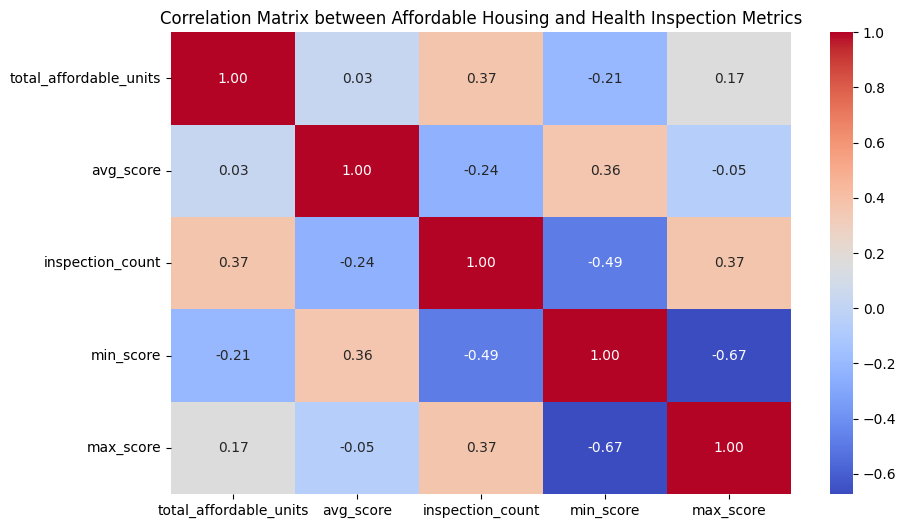

In [28]:
# Compute correlation matrix
correlation_matrix = merged_data[['total_affordable_units', 'avg_score', 'inspection_count', 'min_score', 'max_score']].corr()

# Display correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Visualize the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix between Affordable Housing and Health Inspection Metrics")
plt.show()


### 2. Regression Analysis
Now, we will perform regression analysis to model the relationship between total_affordable_units and the health inspection metrics.

#### a) Regression of `total_affordable_units` on `avg_score`

In [29]:
# Define the predictor and response variables
X_avg_score = merged_data['avg_score']
y_units = merged_data['total_affordable_units']

# Add a constant to the predictor variable
X_avg_score = sm.add_constant(X_avg_score)

# Fit the regression model
model_avg_score = sm.OLS(y_units, X_avg_score).fit()

# Print the summary of the regression model
print("Regression Analysis: Total Affordable Units vs. Average Health Inspection Score")
print(model_avg_score.summary())


Regression Analysis: Total Affordable Units vs. Average Health Inspection Score
                              OLS Regression Results                              
Dep. Variable:     total_affordable_units   R-squared:                       0.001
Model:                                OLS   Adj. R-squared:                 -0.019
Method:                     Least Squares   F-statistic:                   0.03967
Date:                    Fri, 06 Sep 2024   Prob (F-statistic):              0.843
Time:                            23:27:00   Log-Likelihood:                -390.98
No. Observations:                      52   AIC:                             786.0
Df Residuals:                          50   BIC:                             789.9
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

#### b) Regression of `total_affordable_units` on `inspection_count`

In [30]:
# Define the predictor and response variables
X_inspection_count = merged_data['inspection_count']
y_units = merged_data['total_affordable_units']

# Add a constant to the predictor variable
X_inspection_count = sm.add_constant(X_inspection_count)

# Fit the regression model
model_inspection_count = sm.OLS(y_units, X_inspection_count).fit()

# Print the summary of the regression model
print("Regression Analysis: Total Affordable Units vs. Health Inspection Count")
print(model_inspection_count.summary())


Regression Analysis: Total Affordable Units vs. Health Inspection Count
                              OLS Regression Results                              
Dep. Variable:     total_affordable_units   R-squared:                       0.137
Model:                                OLS   Adj. R-squared:                  0.120
Method:                     Least Squares   F-statistic:                     7.927
Date:                    Fri, 06 Sep 2024   Prob (F-statistic):            0.00695
Time:                            23:27:00   Log-Likelihood:                -387.18
No. Observations:                      52   AIC:                             778.4
Df Residuals:                          50   BIC:                             782.3
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
-------------

#### c) Regression of `total_affordable_units` on `min_score`

In [31]:
# Define the predictor and response variables
X_min_score = merged_data['min_score']
y_units = merged_data['total_affordable_units']

# Add a constant to the predictor variable
X_min_score = sm.add_constant(X_min_score)

# Fit the regression model
model_min_score = sm.OLS(y_units, X_min_score).fit()

# Print the summary of the regression model
print("Regression Analysis: Total Affordable Units vs. Minimum Health Inspection Score")
print(model_min_score.summary())


Regression Analysis: Total Affordable Units vs. Minimum Health Inspection Score
                              OLS Regression Results                              
Dep. Variable:     total_affordable_units   R-squared:                       0.043
Model:                                OLS   Adj. R-squared:                  0.024
Method:                     Least Squares   F-statistic:                     2.273
Date:                    Fri, 06 Sep 2024   Prob (F-statistic):              0.138
Time:                            23:27:00   Log-Likelihood:                -389.85
No. Observations:                      52   AIC:                             783.7
Df Residuals:                          50   BIC:                             787.6
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

#### d) Regression of `total_affordable_units` on `max_score`

In [32]:
# Define the predictor and response variables
X_max_score = merged_data['max_score']
y_units = merged_data['total_affordable_units']

# Add a constant to the predictor variable
X_max_score = sm.add_constant(X_max_score)

# Fit the regression model
model_max_score = sm.OLS(y_units, X_max_score).fit()

# Print the summary of the regression model
print("Regression Analysis: Total Affordable Units vs. Maximum Health Inspection Score")
print(model_max_score.summary())


Regression Analysis: Total Affordable Units vs. Maximum Health Inspection Score
                              OLS Regression Results                              
Dep. Variable:     total_affordable_units   R-squared:                       0.028
Model:                                OLS   Adj. R-squared:                  0.009
Method:                     Least Squares   F-statistic:                     1.460
Date:                    Fri, 06 Sep 2024   Prob (F-statistic):              0.233
Time:                            23:27:00   Log-Likelihood:                -390.25
No. Observations:                      52   AIC:                             784.5
Df Residuals:                          50   BIC:                             788.4
Df Model:                               1                                         
Covariance Type:                nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

#### e) Multiple Regression

In [33]:
# Define predictors and response variable
predictors = ['avg_score', 'inspection_count', 'min_score', 'max_score']
response = 'total_affordable_units'

# Add a constant to the predictors for the intercept term
X = merged_data[predictors]
X = sm.add_constant(X)  # Adds a constant term to the predictors
y = merged_data[response]

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     total_affordable_units   R-squared:                       0.157
Model:                                OLS   Adj. R-squared:                  0.085
Method:                     Least Squares   F-statistic:                     2.182
Date:                    Fri, 06 Sep 2024   Prob (F-statistic):             0.0855
Time:                            23:27:00   Log-Likelihood:                -386.57
No. Observations:                      52   AIC:                             783.1
Df Residuals:                          47   BIC:                             792.9
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------


## Regression Analysis Summary

### 1. Total Affordable Units vs. Average Health Inspection Score
- **R-squared:** 0.001
  - The average health inspection score explains very little of the variability in the number of affordable housing units.
- **P-value for `avg_score`:** 0.843
  - Not statistically significant. The average health inspection score is not a significant predictor.

### 2. Total Affordable Units vs. Health Inspection Count
- **R-squared:** 0.137
  - The health inspection count explains a small portion of the variability in the number of affordable housing units.
- **P-value for `inspection_count`:** 0.007
  - Statistically significant. The health inspection count is a significant predictor.

### 3. Total Affordable Units vs. Minimum Health Inspection Score
- **R-squared:** 0.043
  - The minimum health inspection score explains only a small part of the variability in the number of affordable housing units.
- **P-value for `min_score`:** 0.138
  - Not statistically significant. The minimum health inspection score is not a significant predictor.

### 4. Total Affordable Units vs. Maximum Health Inspection Score
- **R-squared:** 0.028
  - The maximum health inspection score explains a very small amount of the variability in the number of affordable housing units.
- **P-value for `max_score`:** 0.233
  - Not statistically significant. The maximum health inspection score is not a significant predictor.

### Summary
- **Significant Predictor:** The `inspection_count` is the only significant predictor of the number of affordable housing units.
- **R-squared Values:** All R-squared values are low, indicating that none of the predictors alone explain a large portion of the variability. Consider exploring multiple regression analysis with additional predictors.

## Visualisation

### 1. Scatter Plots
For scatter plots, we'll plot `total_affordable_units` against each predictor variable

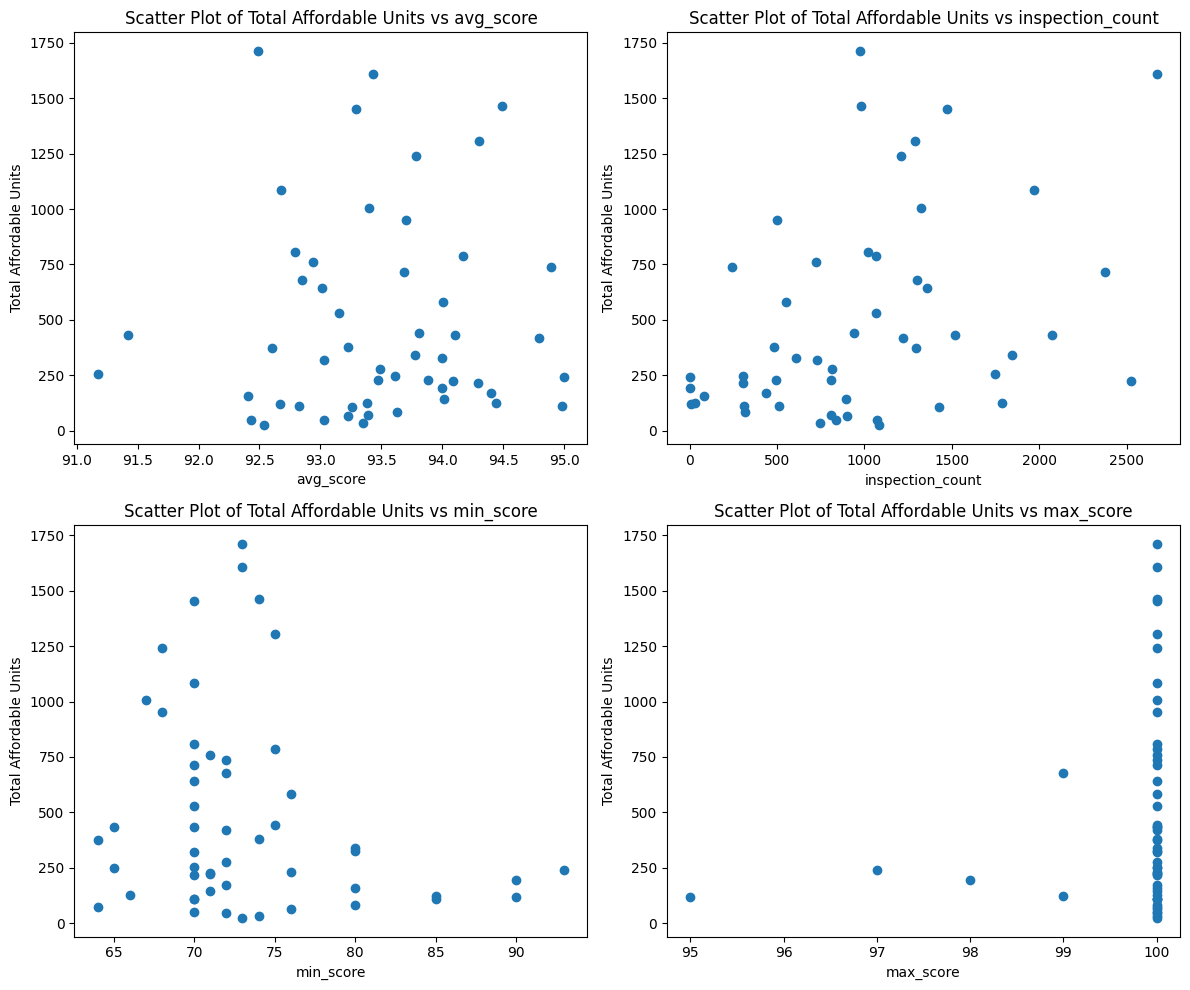

In [34]:
# Define the predictors
predictors = ['avg_score', 'inspection_count', 'min_score', 'max_score']

# Create scatter plots
plt.figure(figsize=(12, 10))

for i, predictor in enumerate(predictors):
    plt.subplot(2, 2, i + 1)
    plt.scatter(merged_data[predictor], merged_data['total_affordable_units'])
    plt.xlabel(predictor)
    plt.ylabel('Total Affordable Units')
    plt.title(f'Scatter Plot of Total Affordable Units vs {predictor}')

plt.tight_layout()
plt.show()


### 2. Pair Plot
To explore relationships between all pairs of variables, use a pair plot.

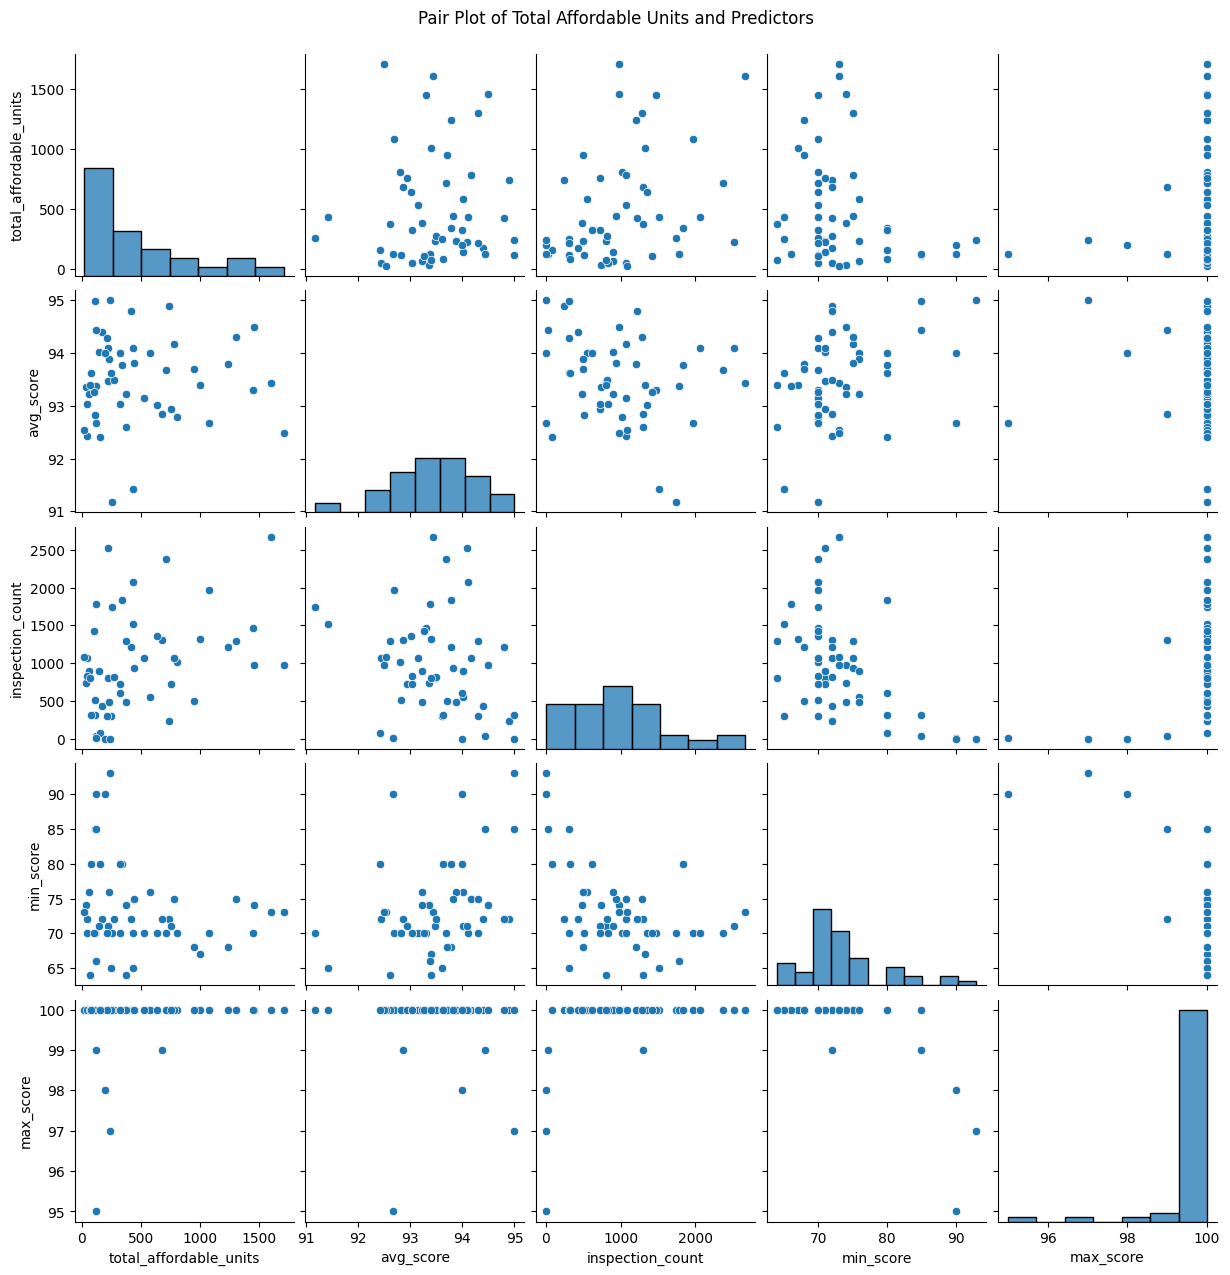

In [35]:
# Create a pair plot
sns.pairplot(merged_data[['total_affordable_units'] + predictors])
plt.suptitle('Pair Plot of Total Affordable Units and Predictors', y=1.02)
plt.show()

## Hypothesis Testing

**Alternative Hypothesis (Hₐ):** There is a significant relationship between the number of affordable housing units and the average health inspection score.  
**Null Hypothesis (H₀):** There is no significant relationship between the number of affordable housing units and the average health inspection score.

#### For regression coefficients, the appropriate test is usually the `t-test`.  
#### I am going ahead with the commonly used significance level: `0.05 (5%)`

### 1. Test for the Significance of Each Predictor
We will use the results from the multiple regression analysis to perform hypothesis tests. In particular, we'll focus on the p-values to determine if the coefficients for each predictor are statistically significant.

In [36]:
# Print the summary from the multiple regression model
print(model.summary())

                              OLS Regression Results                              
Dep. Variable:     total_affordable_units   R-squared:                       0.157
Model:                                OLS   Adj. R-squared:                  0.085
Method:                     Least Squares   F-statistic:                     2.182
Date:                    Fri, 06 Sep 2024   Prob (F-statistic):             0.0855
Time:                            23:27:06   Log-Likelihood:                -386.57
No. Observations:                      52   AIC:                             783.1
Df Residuals:                          47   BIC:                             792.9
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------


### 2. Perform Individual Hypothesis Tests

In [37]:
# Extracting coefficients, standard errors, t-stats, and p-values from the model
coefficients = model.params
std_errors = model.bse
t_stats = coefficients / std_errors
p_values = model.pvalues

# Create a DataFrame for easier viewing
results_df = pd.DataFrame({
    'Coefficient': coefficients,
    'Standard Error': std_errors,
    'T-Statistic': t_stats,
    'P-Value': p_values
})

print("Individual Hypothesis Tests Results:")
print(results_df)

# Example for one specific predictor 'inspection_count'
predictor = 'inspection_count'
coef = coefficients[predictor]
std_err = std_errors[predictor]
t_stat = coef / std_err
p_value = 2 * (1 - stats.norm.cdf(abs(t_stat)))

print(f'\nT-statistic for {predictor}: {t_stat:.3f}')
print(f'P-value for {predictor}: {p_value:.3f}')

Individual Hypothesis Tests Results:
                  Coefficient  Standard Error  T-Statistic   P-Value
const            -5673.275745    11169.599152    -0.507921  0.613884
avg_score           84.070864       83.135284     1.011254  0.317073
inspection_count     0.253906        0.107120     2.370297  0.021928
min_score           -7.248508       14.882133    -0.487061  0.628479
max_score          -14.224937       99.701524    -0.142675  0.887157

T-statistic for inspection_count: 2.370
P-value for inspection_count: 0.018


## Deciding If the Null Hypothesis Should Be Rejected
**Compare the p-value to the significance level (α):**
   - If $ p \leq \alpha $, reject the null hypothesis.
   - If $ p > \alpha $, do not reject the null hypothesis.


In [38]:
# Set significance level
alpha = 0.05

# Decision rule
if p_value <= alpha:
    print(f"The p-value ({p_value:.3f}) is less than the significance level ({alpha}).")
    print("Reject the null hypothesis and accept the alternative hypothesis.")
else:
    print(f"The p-value ({p_value:.3f}) is greater than the significance level ({alpha}).")
    print("Do not reject the null hypothesis!")


The p-value (0.018) is less than the significance level (0.05).
Reject the null hypothesis and accept the alternative hypothesis.


# Conclusion Report

## Summary

In this analysis, we explored the relationship between the number of affordable housing units and various health inspection metrics (average score, inspection count, minimum score, and maximum score). We performed both statistical analysis and visualization to understand these relationships better.

### Statistical Analysis

#### Regression Analysis

We conducted multiple linear regression analysis to model the relationship between `total_affordable_units` and the health inspection metrics. The results are summarized below:

- **Regression Model Summary:**
  - **R-squared:** 0.157
  - **Adjusted R-squared:** 0.085
  - **F-statistic:** 2.182
  - **Prob (F-statistic):** 0.0855

- **Coefficients:**
  - **Intercept (const):** -5673.276 (p-value: 0.614)
  - **Average Score (avg_score):** 84.071 (p-value: 0.317)
  - **Inspection Count (inspection_count):** 0.254 (p-value: 0.022)
  - **Minimum Score (min_score):** -7.249 (p-value: 0.628)
  - **Maximum Score (max_score):** -14.225 (p-value: 0.887)

#### Individual Hypothesis Tests

For each predictor variable, we conducted hypothesis tests to determine their significance:

1. **Average Score (avg_score):**
   - **T-Statistic:** 1.011
   - **P-Value:** 0.317
   - **Conclusion:** The p-value is greater than the significance level (0.05), so we do not reject the null hypothesis. There is insufficient evidence to suggest that the average score significantly affects the number of affordable housing units.

2. **Inspection Count (inspection_count):**
   - **T-Statistic:** 2.370
   - **P-Value:** 0.022
   - **Conclusion:** The p-value is less than the significance level (0.05), so we reject the null hypothesis. There is significant evidence to suggest that the inspection count positively affects the number of affordable housing units.

3. **Minimum Score (min_score):**
   - **T-Statistic:** -0.487
   - **P-Value:** 0.628
   - **Conclusion:** The p-value is greater than the significance level (0.05), so we do not reject the null hypothesis. There is insufficient evidence to suggest that the minimum score significantly affects the number of affordable housing units.

4. **Maximum Score (max_score):**
   - **T-Statistic:** -0.143
   - **P-Value:** 0.887
   - **Conclusion:** The p-value is greater than the significance level (0.05), so we do not reject the null hypothesis. There is insufficient evidence to suggest that the maximum score significantly affects the number of affordable housing units.

### Visualization

We used scatter plots and heatmaps to visually assess the relationships between the number of affordable housing units and the health inspection metrics. These visualizations helped in understanding the potential correlations and patterns in the data.

### Final Thoughts

The analysis revealed that while some of the health inspection metrics did not show a significant relationship with the number of affordable housing units, the inspection count did show a positive and significant effect. This insight could be valuable in making data-driven decisions regarding affordable housing.



## Numbered Sources of References:

1. **ChatGPT prompt**:  
   "Given are the URLs of two datasets:
   - https://catalog.data.gov/dataset/restaurant-and-market-health-inspections
   - https://catalog.data.gov/dataset/hcidla-affordable-housing-projects-list-2003-to-present  
   Help me with the Python code to download these data so that I can load them on Pandas df"  

2. [Strategies for handling missing values](https://www.dasca.org/world-of-data-science/article/strategies-for-handling-missing-values-in-data-analysis)

3. **Pandas Documentation:** [Different choices for indexing](https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy)

4. **ChatGPT prompt**:  
   "Help me with the code for summarising each file by ZIP code using SQL, alongside ensuring the right type of summarization (sum, mean, max etc.) for the other variables"

5. **ChatGPT prompt**:  
   "Help me with the code for saving Summarized DataFrames to the SQLite Database"

## General (Additional) Sources of References:
### Lecture Slides of DS203 and EE353
### MLForSmartMonkeys by Prof. Amit Sethi
### Websites:
- [Markdown Cheatsheet (for fluent notes)](https://www.markdownguide.org/cheat-sheet/)
- [Kaggle Notebook-1](https://www.kaggle.com/code/agrawaladitya/step-by-step-data-preprocessing-eda)
- [Kaggle Notebook-2](https://www.kaggle.com/code/ekami66/detailed-exploratory-data-analysis-with-python) 
- [Quantile-Quartile Plots](https://www.geeksforgeeks.org/quantile-quantile-plots/)
- [Split Pandas DF by Column Values](https://www.geeksforgeeks.org/split-pandas-dataframe-by-column-value/)
- [SciPy Documentation](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ranksums.html)
- [Hypothesis Testing in Statistics](https://www.simplilearn.com/tutorials/statistics-tutorial/hypothesis-testing-in-statistics)

$$--------End \space  of \space  Assignment--------$$